In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({"figure.figsize": (20, 10), "figure.dpi": 120})

from src.ETL import *
from src.dashboard import get_line_fig, add_slider, plot_forecast

from darts.models import NaiveSeasonal, LinearRegressionModel
from darts import TimeSeries, concatenate
from darts.metrics import rmse, mase, mape, r2_score
from darts.utils.statistics import (
    plot_acf,
    plot_pacf,
    plot_residuals_analysis,
    plot_hist,
)
from darts.dataprocessing.transformers import Mapper, Diff


ROOT_PATH = "data Toronto rents 2025Q1"
# ROOT_PATH = 'data Toronto rents'

## Covariates engineering

<Axes: xlabel='Date'>

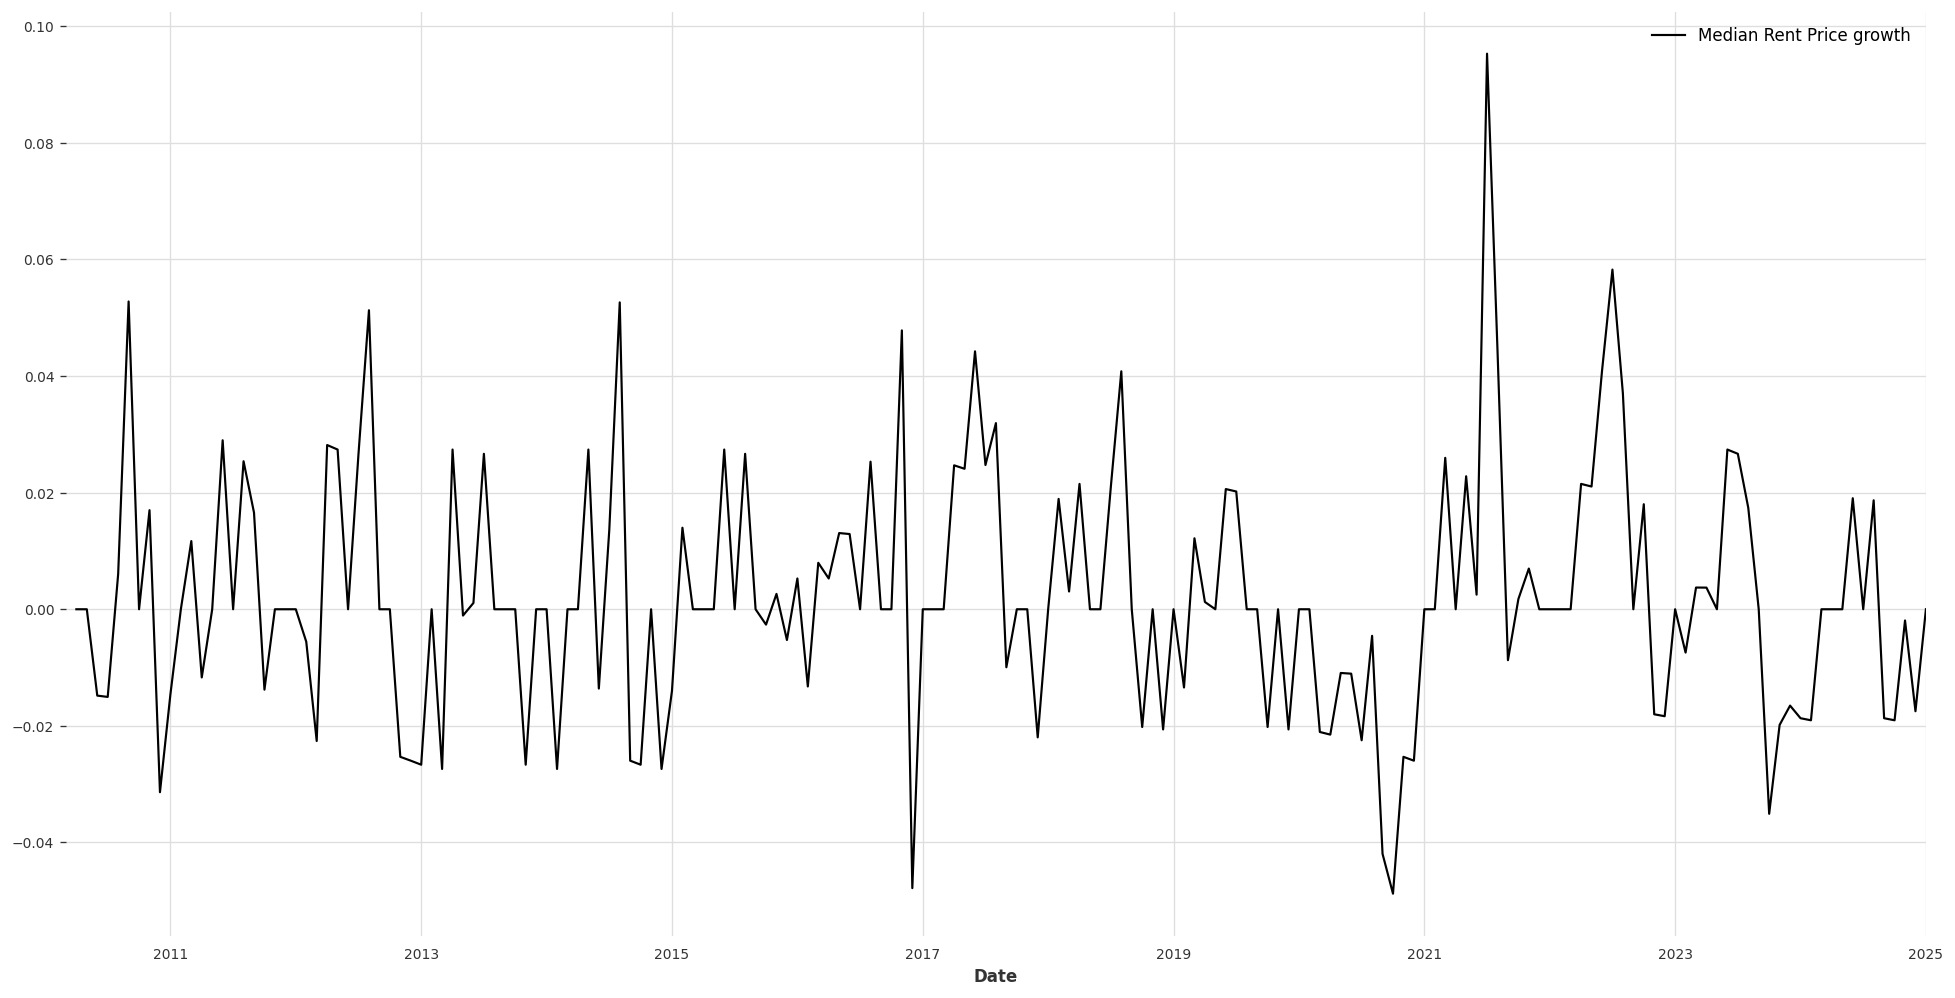

In [8]:
cpi = etl_pipeline(
    extract_data_from_StatsCanada_API,
    {"vector_id": 41691954, "latest_n": 600, "new_name": "CPI"},
    num_lags=0,
)
df1 = etl_pipeline(
    extract_data_from_HS_json,
    {
        "file_path": f"{ROOT_PATH}/rent.json",
        "cols": ["price_rent"],
        "new_names": ["Median Rent Price"],
    },
    transform_dict={"Median Rent Price": growth(1)},
    num_lags=13,
    lagged_cols=["Median Rent Price growth"],
)
df1 = df1  # [:-1]

target = "Median Rent Price growth"
target2 = "Median Rent Price"
df1[[target]].plot()
# df1[["Rent_real", "Rent"]].plot()

In [ ]:
df_cov = df1.join(
    etl_pipeline(
        extract_data_from_StatsCanada_CSV,
        {
            "file_path": f"{ROOT_PATH}/14100383.csv",
            "in_col": "Labour force characteristics",
            "out_cols": [
                "Participation rate",
                "Employment rate",
                "Unemployment rate",
                "Population",
                "Labour force",
            ],
            "filters": {
                "GEO": "Toronto, Ontario",
                "Data type": "Seasonally adjusted",
                "Statistics": "Estimate",
            },
        },
        transform_dict={
            "Unemployment rate": [growth(1), growth(12), diff(1), diff(12)],
            "Participation rate": [diff(1), diff(12)],
            "Population": [growth(1), growth(12)],
            "Labour force": [growth(12)],
        },
    )
)

# df_cov = df_cov.join(etl_pipeline(extract_data_from_CREA, file_path = f'{ROOT_PATH}/MLS_HPI/Seasonally Adjusted_June_2024.xlsx', sheet_name = 'GREATER_TORONTO',
#                 in_col = "Apartment_Benchmark_SA", new_names = ["HPI"]),
#                 transform_dict = {"HPI": [growth(1), compose(growth(1), to_real(cpi))]}))

# df_cov = df_cov.join(etl_pipeline(extract_data_from_StatsCanada_CSV, {file_path = f'{ROOT_PATH}/1410022201_databaseLoadingData.csv',
#                             in_col = "Estimate",
#                             out_cols = ["Employment for all employees", "Average weekly earnings including overtime for all employees",
#                                         "Employment for salaried employees", "Average weekly earnings including overtime for salaried employees"],
#                             new_names = ["Employment", "Avg weekly earnings", "Employment salaried", "Avg weekly earnings salaried"]},
#                             transform_dict = {"Employment": [growth(1), growth(12)],
#                                               "Avg weekly earnings": [growth(1), growth(12)],}
#                             ))
df_cov = df_cov.join(
    etl_pipeline(
        extract_data_from_StatsCanada_CSV,
        {
            "file_path": f"{ROOT_PATH}/34100145.csv",
            "in_col": None,
            "out_cols": ["Mortgage rate 5y"],
        },
        transform_dict={"Mortgage rate 5y": [diff(1), diff(12), growth(1), growth(12)]},
    )
)

df_cov = df_cov.join(
    etl_pipeline(
        extract_data_from_StatsCanada_CSV,
        {
            "file_path": f"{ROOT_PATH}/18100205.csv",
            "in_col": "New housing price indexes",
            "out_cols": ["Total (house and land)", "House only", "Land only"],
            "new_names": ["NHPI", "House only", "Land only"],
            "filters": {"GEO": "Toronto, Ontario"},
        },
        transform_dict={
            "NHPI": [growth(1), compose(growth(1), to_real(cpi))],
            "House only": [growth(1), compose(growth(1), to_real(cpi))],
            "Land only": [growth(1), compose(growth(1), to_real(cpi))],
        },
    )
)


df_cov = df_cov.join(
    etl_pipeline(
        extract_data_from_HS_json,
        {
            "file_path": f"{ROOT_PATH}/rent.json",
            "cols": ["rent_count", "rent_listing_count"],
            "new_names": ["Total Leased", "New Listings"],
        },
        transform_dict={
            "Total Leased": [growth(1), growth(12)],
            "New Listings": [growth(1), growth(12)],
        },
    )
)

df_cov = df_cov.join(cpi)
df_cov["CPI growth"] = df_cov["CPI"].pct_change()

df_cov["LNLR"] = df_cov["Total Leased"] / df_cov["New Listings"]
# df_cov["LNLR_growth"] = df_cov["LNLR"].pct_change()
df_cov["LNLR_growth12"] = df_cov["LNLR"].pct_change(12)

df_cov = make_lags(df_cov, 12, ["LNLR", "LNLR_growth12"])

df_cov = df_cov.ffill().bfill()
df_cov = df_cov[sorted(df_cov.columns)]

# df_cov

corr_lag = df_cov.corr()[target][df_cov.corr()[target].abs() > 0.2].sort_values()
df_cov.corr()

,CPI,CPI growth,Employment rate,Employment rate lag 1,Employment rate lag 10,Employment rate lag 11,Employment rate lag 12,Employment rate lag 13,Employment rate lag 14,Employment rate lag 15,...,Unemployment rate lag 17,Unemployment rate lag 18,Unemployment rate lag 2,Unemployment rate lag 3,Unemployment rate lag 4,Unemployment rate lag 5,Unemployment rate lag 6,Unemployment rate lag 7,Unemployment rate lag 8,Unemployment rate lag 9
CPI,1.000000,0.364666,-0.053590,-0.038401,0.088585,0.094463,0.102409,0.106440,0.106950,0.101788,...,-0.269746,-0.254202,-0.201530,-0.208177,-0.209651,-0.240754,-0.254594,-0.265430,-0.275473,-0.286511
CPI growth,0.364666,1.000000,0.135879,0.065897,-0.042740,0.035296,0.023307,0.017444,0.004035,0.009282,...,0.047619,0.043689,-0.120077,-0.088054,-0.108069,-0.146810,-0.183592,-0.160648,-0.077531,-0.035588
Employment rate,-0.053590,0.135879,1.000000,0.877101,0.072126,0.024099,-0.023173,-0.081840,-0.158985,-0.222212,...,0.356901,0.358814,-0.464168,-0.312023,-0.204523,-0.134274,-0.101495,-0.089682,-0.084814,-0.061771
Employment rate lag 1,-0.038401,0.065897,0.877101,1.000000,0.117132,0.070068,0.020392,-0.026009,-0.083013,-0.160717,...,0.324467,0.355919,-0.639150,-0.466353,-0.316414,-0.201063,-0.135706,-0.104540,-0.092143,-0.086684
Employment rate lag 10,0.088585,-0.042740,0.072126,0.117132,1.000000,0.874097,0.654284,0.442162,0.279121,0.168356,...,-0.107659,-0.101469,-0.330235,-0.351815,-0.371545,-0.411858,-0.487531,-0.590471,-0.699259,-0.783962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unemployment rate lag 5,-0.240754,-0.146810,-0.134274,-0.201063,-0.411858,-0.367212,-0.344121,-0.319629,-0.271529,-0.187896,...,0.196605,0.153777,0.688683,0.800844,0.909799,1.000000,0.912192,0.803825,0.694892,0.607798
Unemployment rate lag 6,-0.254594,-0.183592,-0.101495,-0.135706,-0.487531,-0.409283,-0.363977,-0.340761,-0.317618,-0.266198,...,0.232251,0.193754,0.599198,0.690232,0.800650,0.912192,1.000000,0.912412,0.804643,0.696469
Unemployment rate lag 7,-0.265430,-0.160648,-0.089682,-0.104540,-0.590471,-0.483764,-0.404601,-0.358991,-0.337348,-0.309395,...,0.279655,0.226881,0.531094,0.601956,0.692008,0.803825,0.912412,1.000000,0.913188,0.806471
Unemployment rate lag 8,-0.275473,-0.077531,-0.084814,-0.092143,-0.699259,-0.585656,-0.478065,-0.398952,-0.355332,-0.328840,...,0.356886,0.274571,0.479815,0.534550,0.604764,0.694892,0.804643,0.913188,1.000000,0.913973


In [4]:
plot_list = ["Unemployment rate"]  # [col for col in df_cov.columns if "lag" not in col]
for i in plot_list:
    get_line_fig(df_cov, i, target).show()
    add_slider(df_cov, i, target).show()

In [10]:
print(corr_lag.to_string())

New Listings growth12              -0.360223
Employment rate lag 14             -0.345651
New Listings growth12 lag 1        -0.341199
Unemployment rate diff12           -0.338452
Unemployment rate growth12         -0.332457
Employment rate lag 15             -0.328403
Unemployment rate diff12 lag 2     -0.326439
Unemployment rate diff12 lag 1     -0.321467
Unemployment rate growth12 lag 1   -0.317354
Total Leased growth lag 9          -0.310012
Unemployment rate growth12 lag 2   -0.302323
New Listings growth12 lag 2        -0.285626
Employment rate lag 13             -0.281626
Unemployment rate diff lag 5       -0.280952
Unemployment rate diff12 lag 3     -0.276309
New Listings growth lag 8          -0.274689
Total Leased growth lag 8          -0.265532
Unemployment rate growth lag 5     -0.264944
Unemployment rate growth12 lag 3   -0.256011
Employment rate lag 12             -0.246141
Unemployment rate diff12 lag 4     -0.241880
Population growth lag 18           -0.234075
Participat

## Forecasting and Backtesting utils

In [11]:
def eval_results(
    y, f, model, metrics, inverse_transform=False, last_points_only=False, title=" "
):

    if inverse_transform:
        to_exp = Mapper(lambda x: np.exp(x))
        if not isinstance(f, list):
            f = (
                to_exp.transform(f.cumsum())
                * y[y[: f.time_index[0]].time_index[-2]].last_value()
            )
            # f = TimeSeries.from_dataframe(inv_growth(f.pd_dataframe(), y.last_value()))

        else:
            for i in range(len(f)):
                f[i] = (
                    to_exp.transform(f[i].cumsum())
                    * y[y[: f[i].time_index[0]].time_index[-2]].last_value()
                )

    b = model.backtest(
        y, historical_forecasts=f, last_points_only=last_points_only, metric=metrics
    )

    print("------------" + title + "------------")
    for i, metric in enumerate(metrics):
        print(metric.__name__ + ": %.4f" % b[i])

    figure = plt.figure()
    y.plot()

    if not isinstance(f, list):
        f.plot()
    else:
        for i, s in enumerate(f):
            s.plot(label=("Backtest" if i == 0 else "_nolegend_"), color="blue")

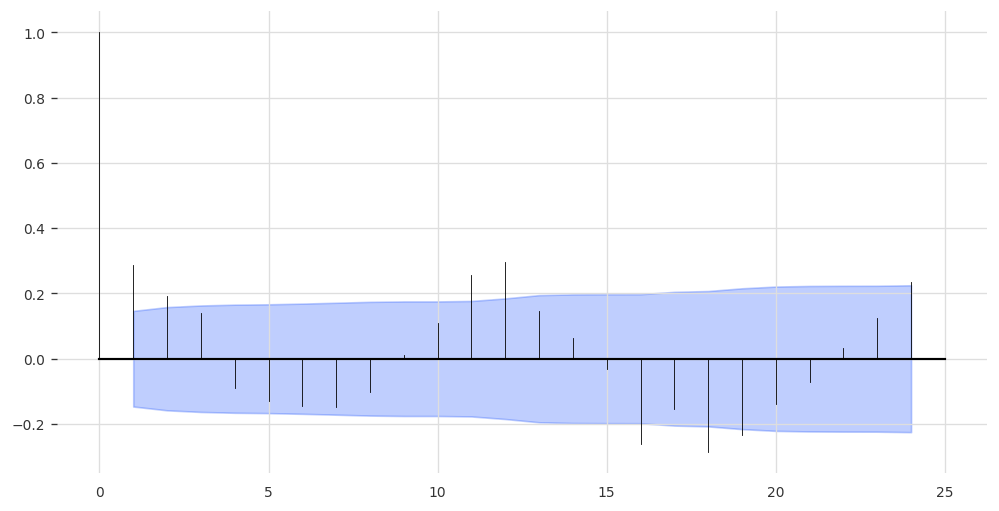

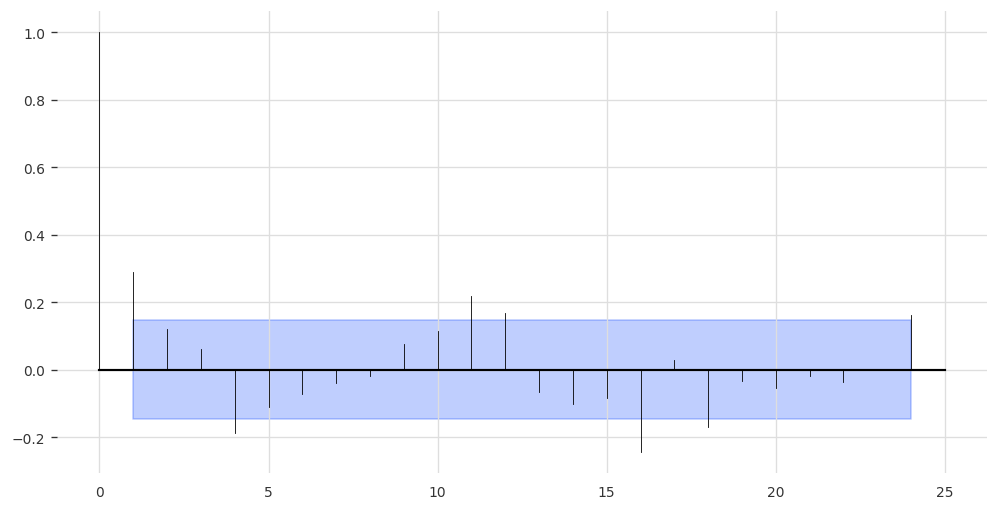

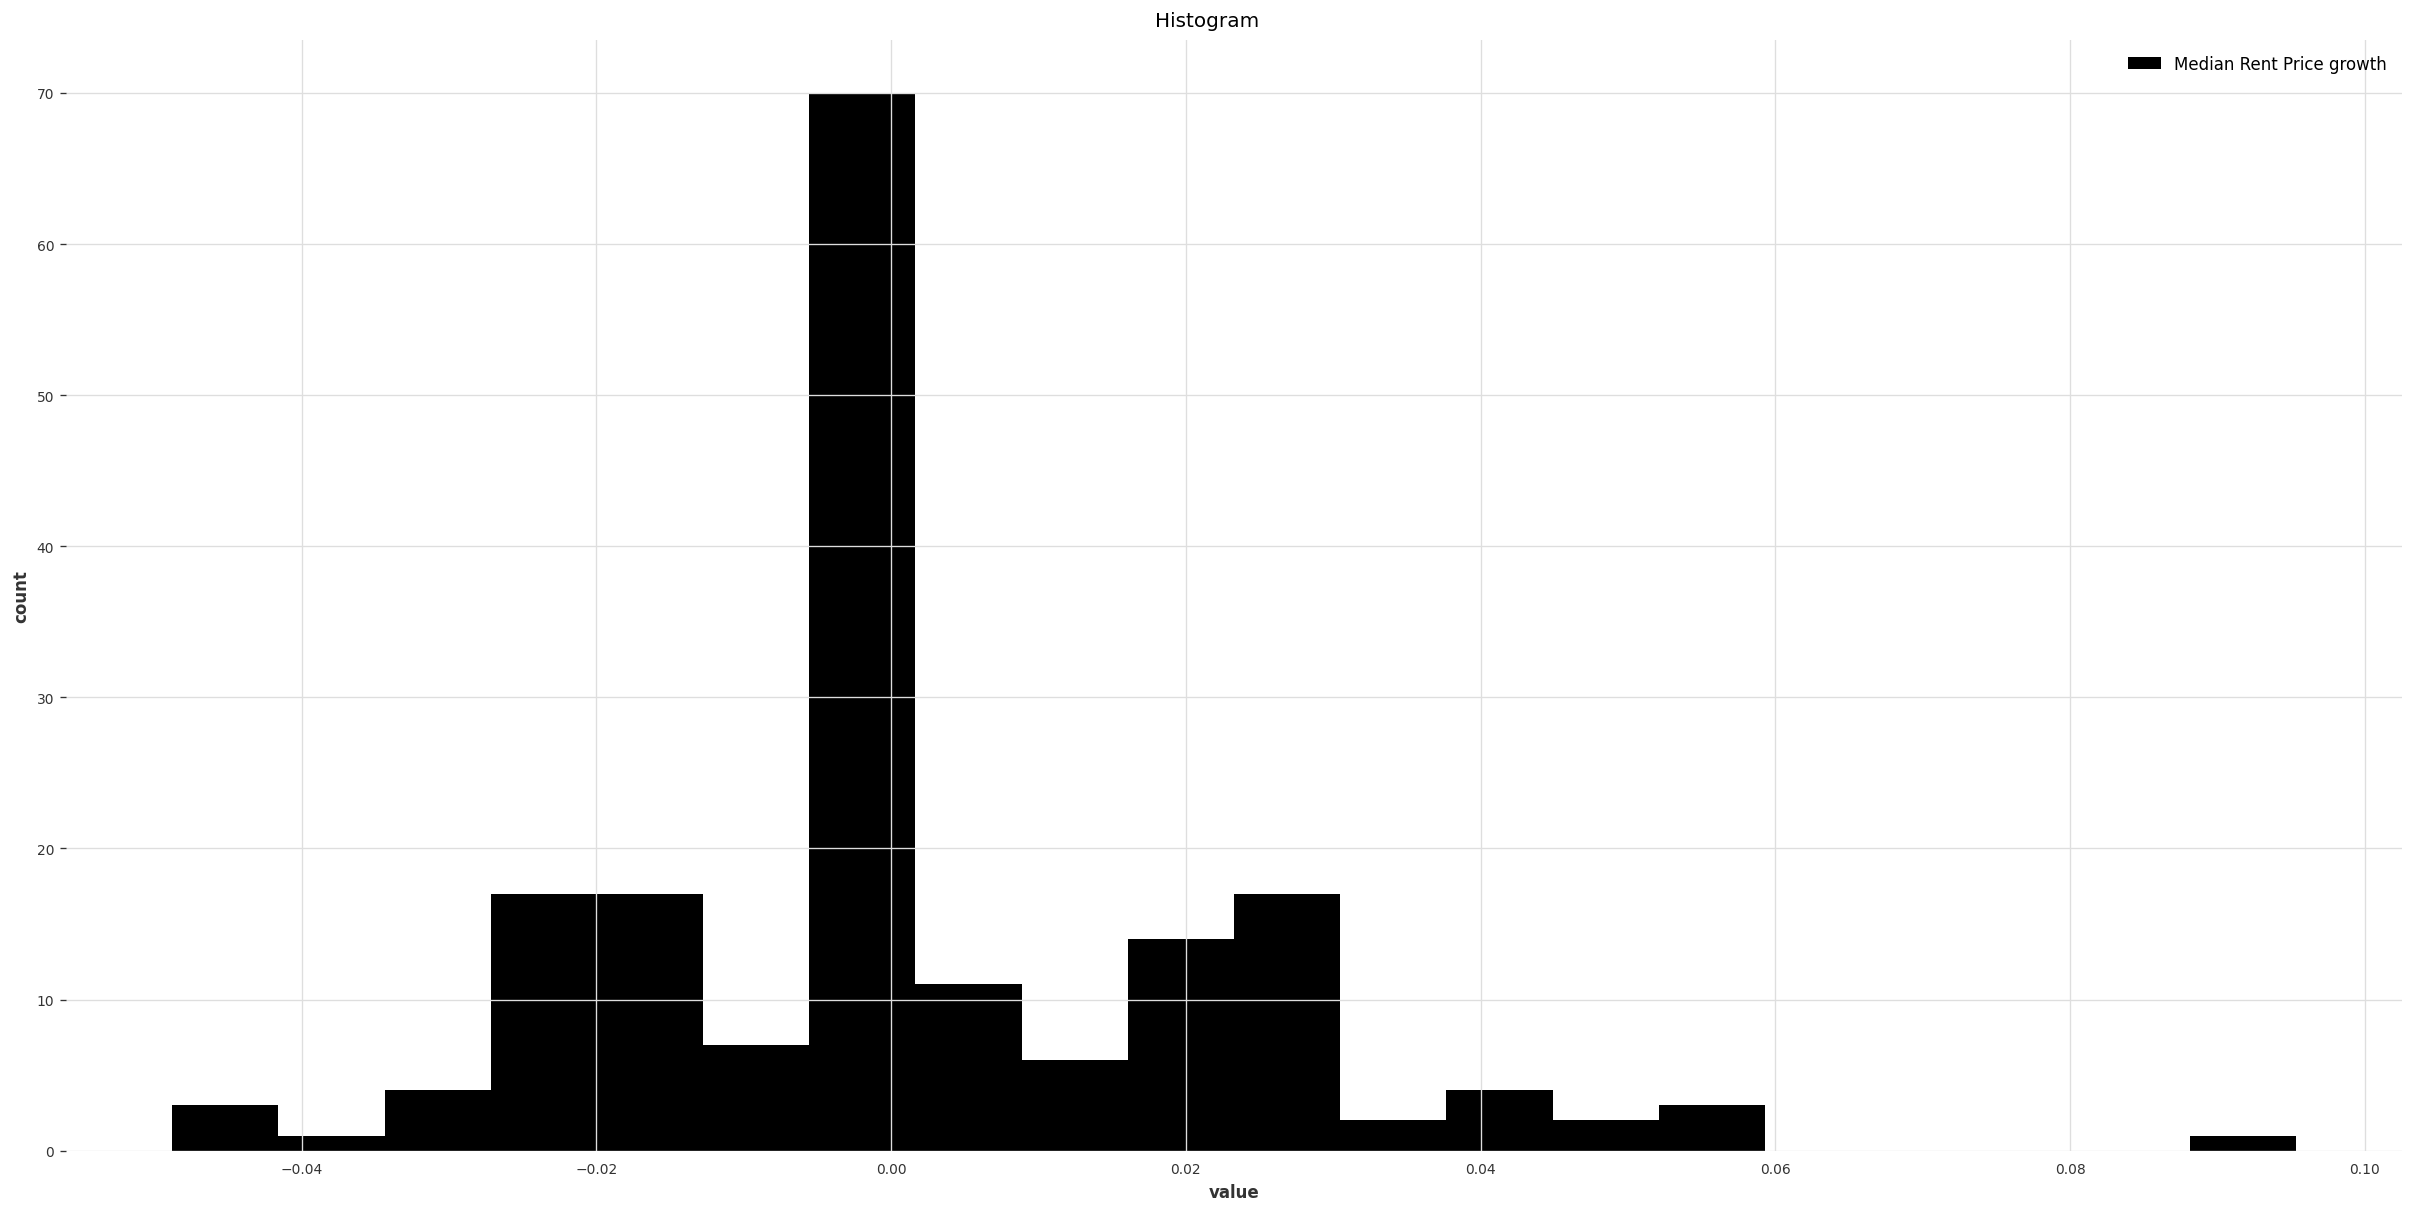

In [52]:
test_split_time = pd.Timestamp("20200925")
features = [
    "Unemployment rate diff",
    "NHPI growth",
    "LNLR",
]

y = TimeSeries.from_dataframe(df_cov, value_cols=target)
y_train, y_test = y.split_before(test_split_time)

y1 = TimeSeries.from_dataframe(df_cov, value_cols="Median Rent Price")

cov = TimeSeries.from_dataframe(df_cov, value_cols=features)
plot_acf(y)
plot_pacf(y)
plot_hist(y, bins=20)

## Linear Regression

------------Train up to 2020-09-25 00:00:00------------
rmse: 0.0169
mase: 0.6080
r2_score: 0.3375
------------Train up to 2020-09-25 00:00:00------------
rmse: 190.3042
mase: 6.3440
mape: 6.4735
r2_score: 0.6647


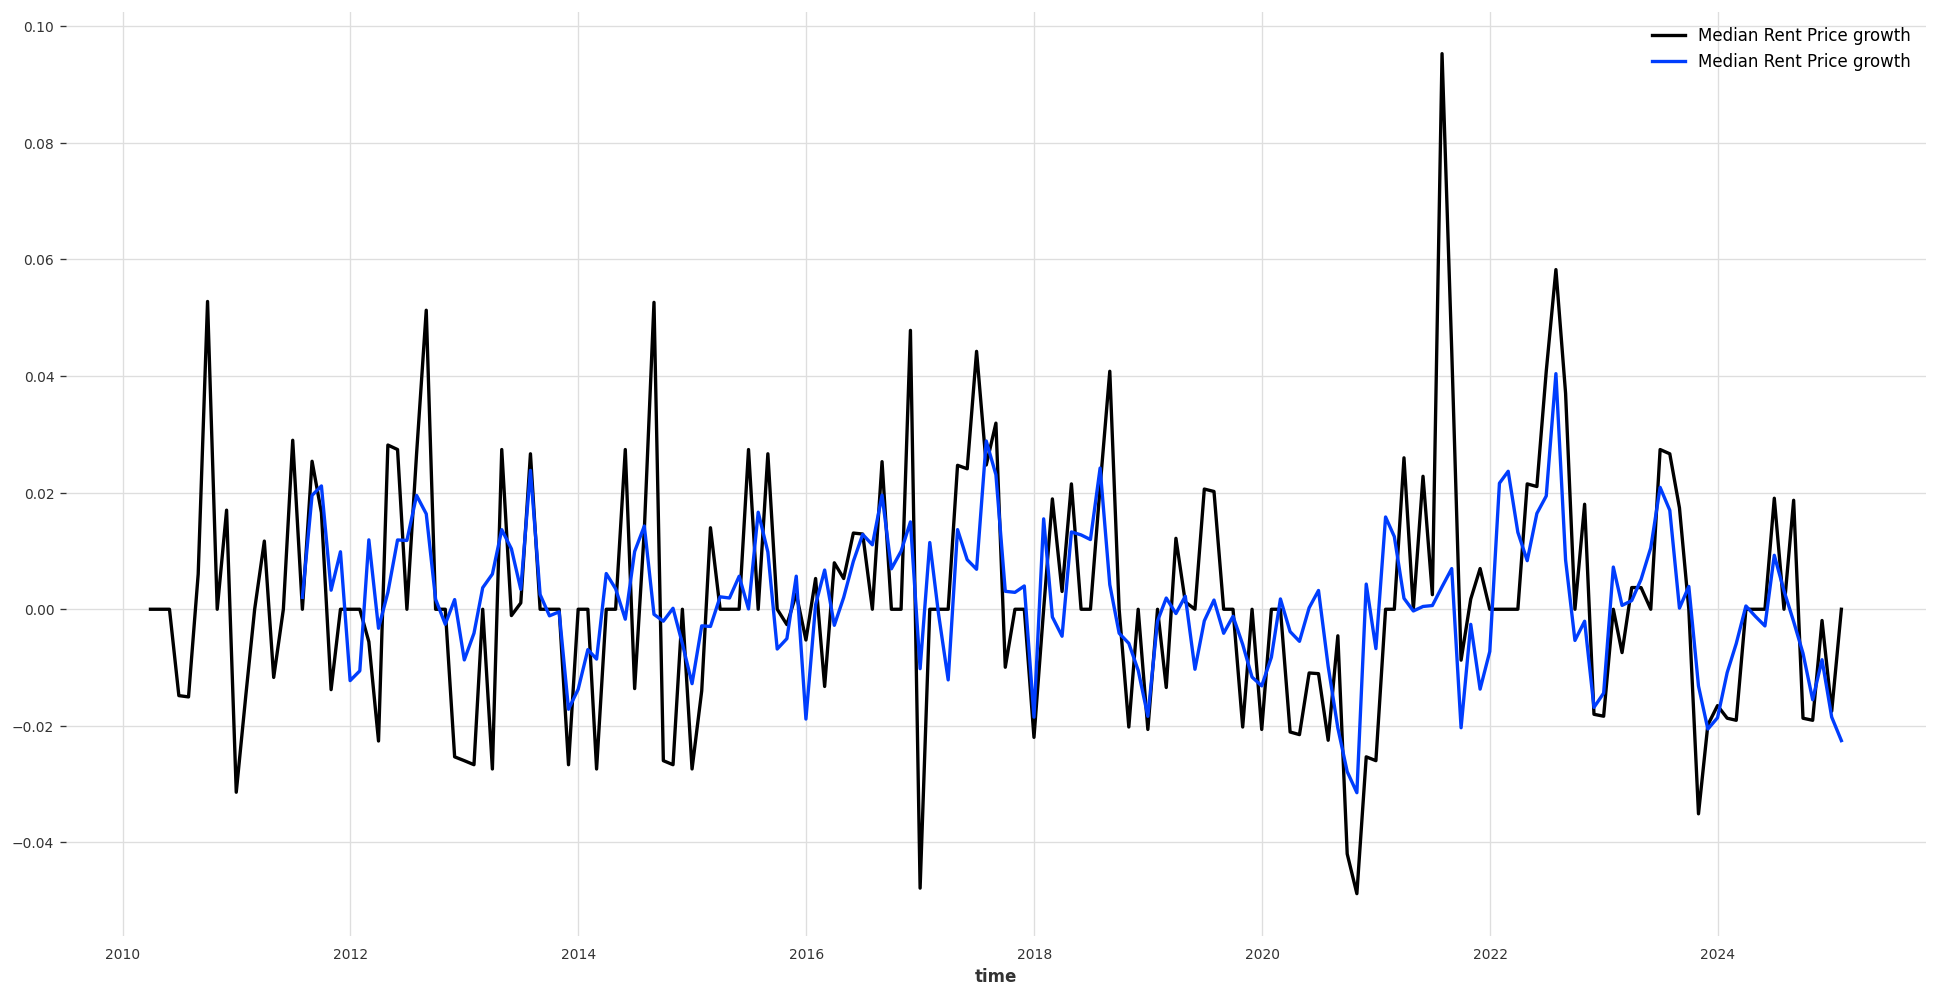

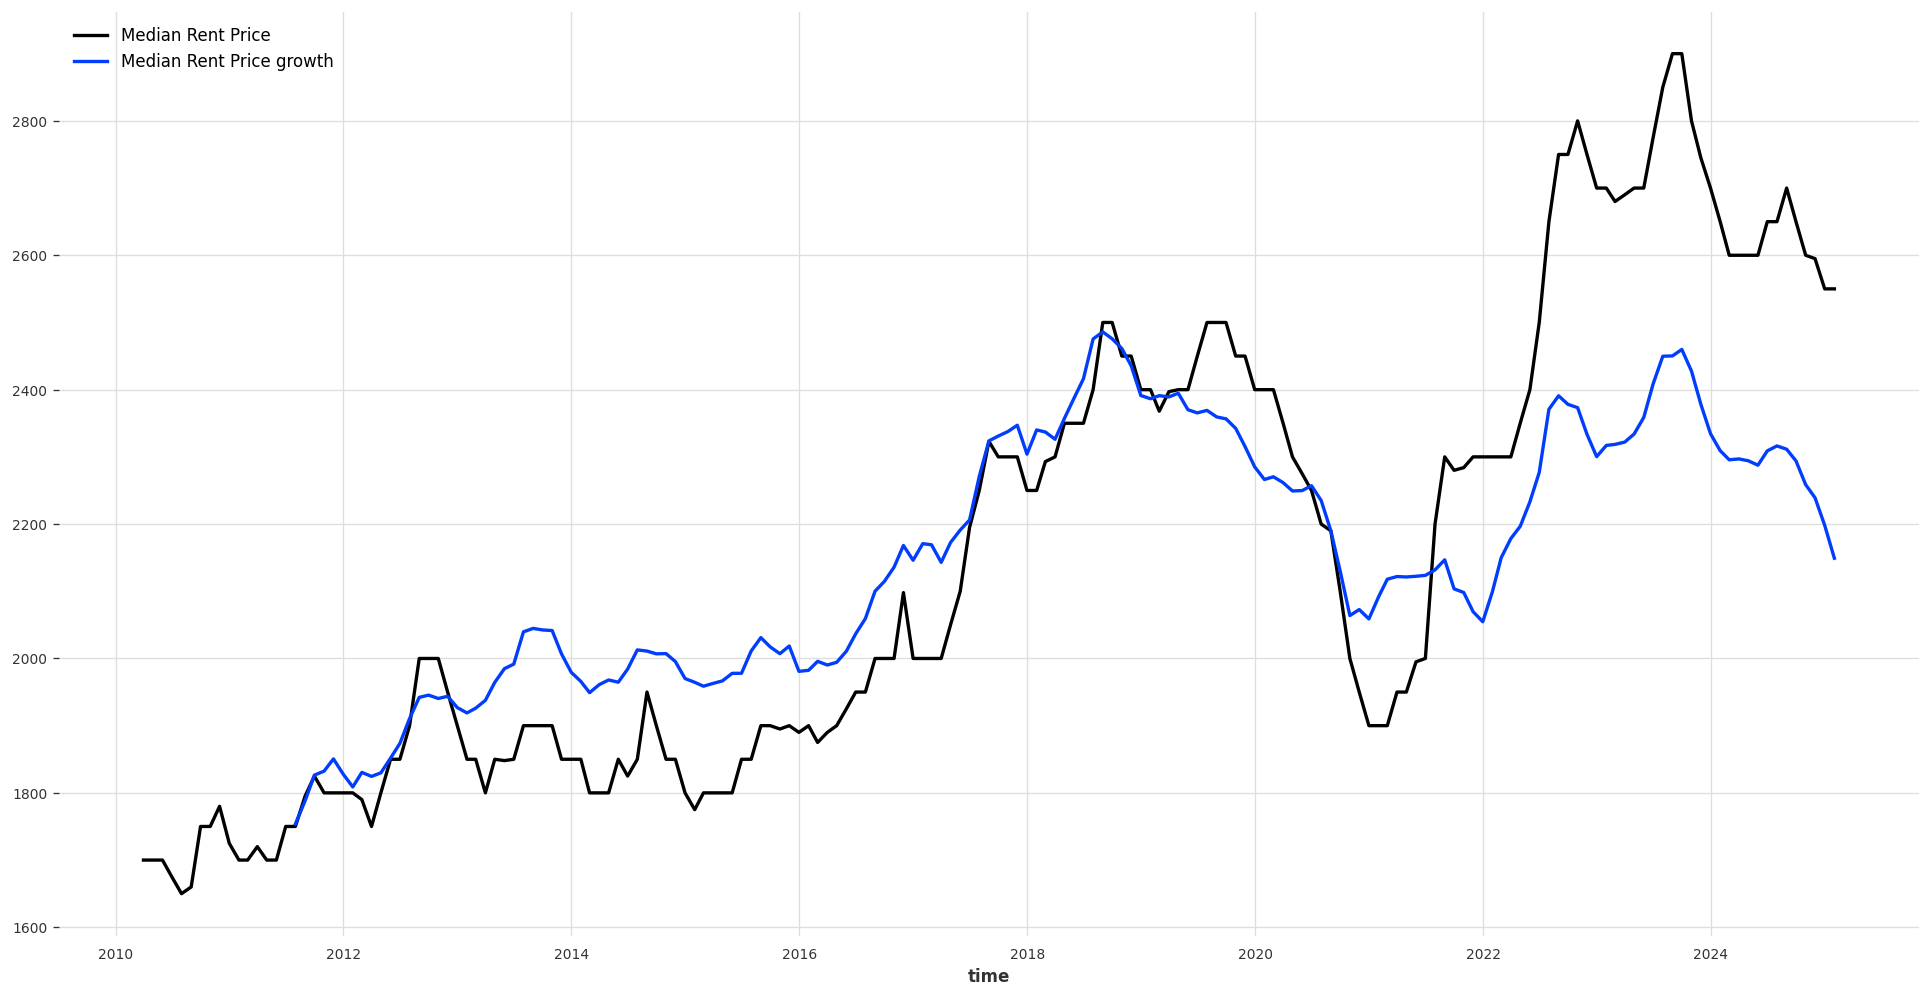

In [55]:
LR = LinearRegressionModel(
    lags=[-1, -4, -11, -12, -16],  # [-1,-12],
    lags_future_covariates={
        "Unemployment rate diff": [-5],
        "NHPI growth": [-3, -15],
        "LNLR": [-3],
    },  # Unemployment rate diff
    output_chunk_length=1,
    # likelihood='quantile',
    # quantile=0.5,
    # alpha=0
)
LR.fit(y_train, future_covariates=cov)

f = LR.historical_forecasts(
    y,
    future_covariates=cov,
    start=None,
    forecast_horizon=1,
    stride=1,
    last_points_only=True,
    retrain=False,
    overlap_end=False,
    verbose=False,
)

eval_results(
    y,
    f,
    LR,
    [rmse, mase, r2_score],
    last_points_only=True,
    title="Train up to " + str(test_split_time),
)
eval_results(
    y1,
    f,
    LR,
    [rmse, mase, mape, r2_score],
    inverse_transform=True,
    last_points_only=True,
    title="Train up to " + str(test_split_time),
)

## Backtesting vs Benchmark

------------Backtest------------
rmse: 0.0154
mase: 0.6898
------------Backtest------------
rmse: 57.3125
mase: 1.8263
mape: 2.1761
------------ ------------
rmse: 0.0184
mase: 0.8264
------------ ------------
rmse: 71.7511
mase: 2.2831
mape: 2.7172


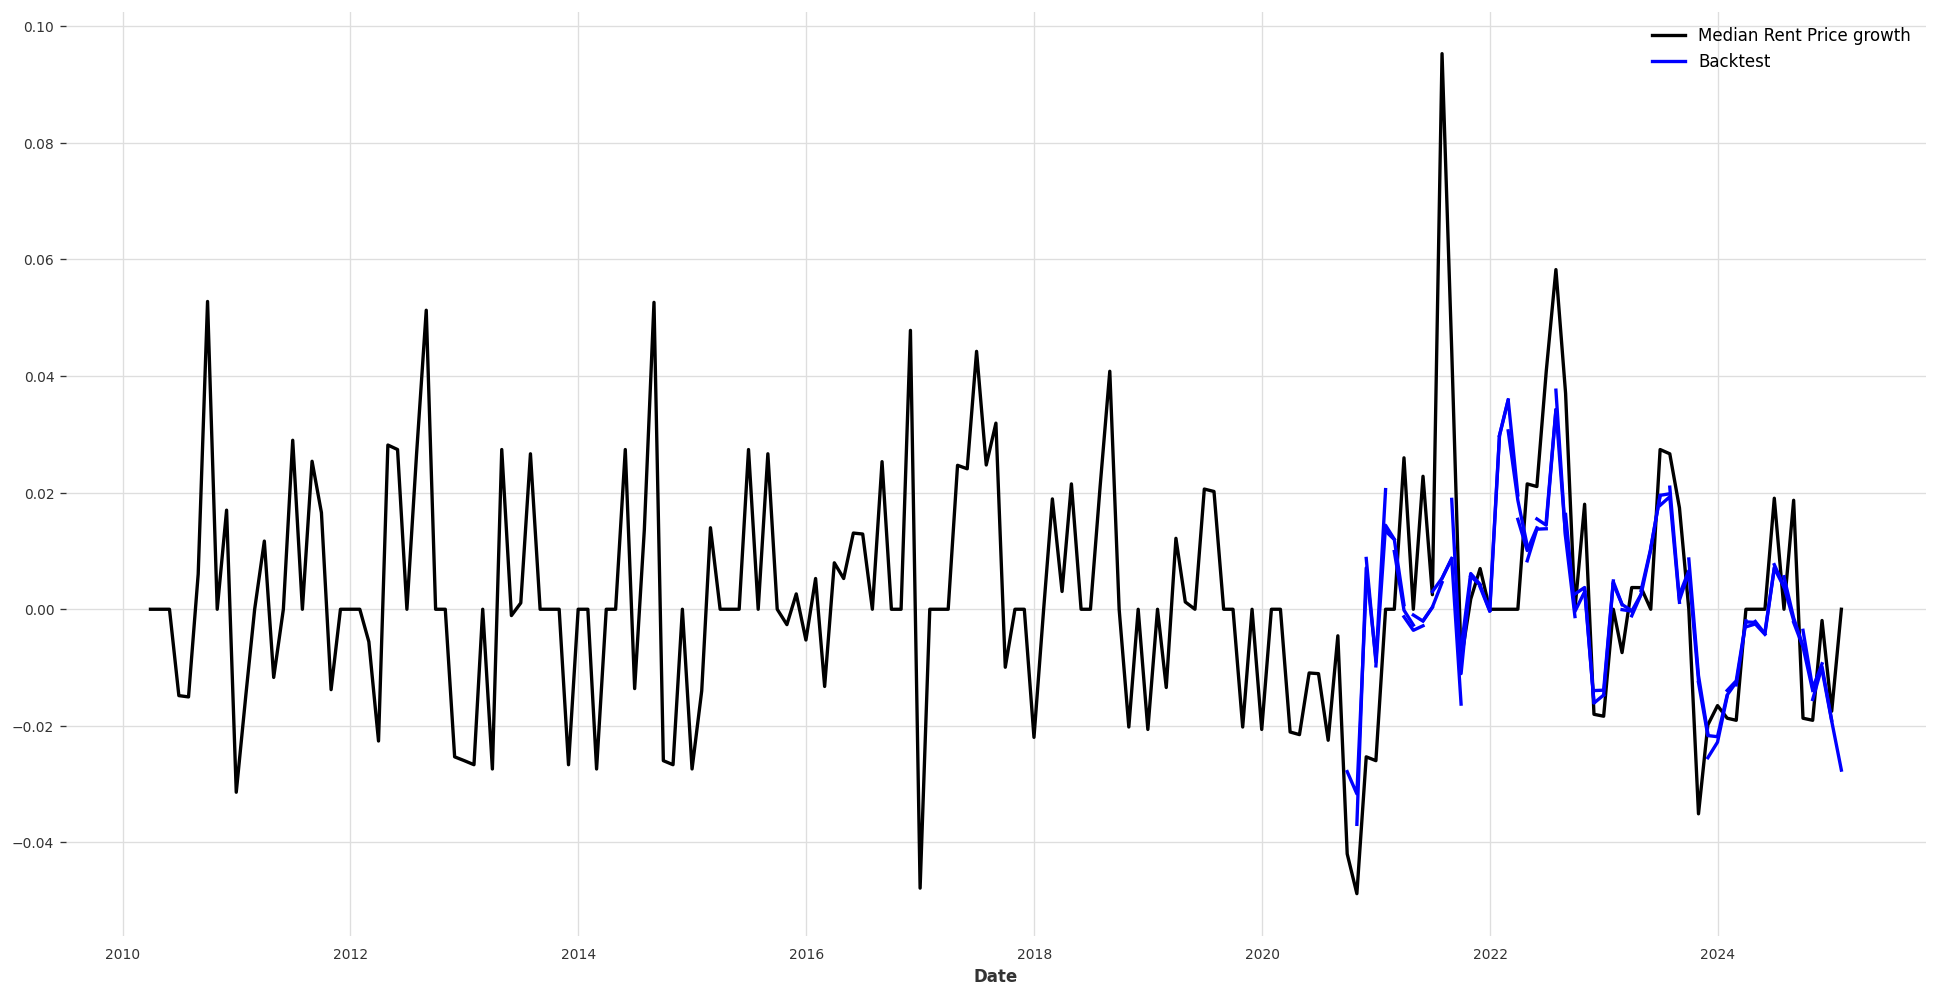

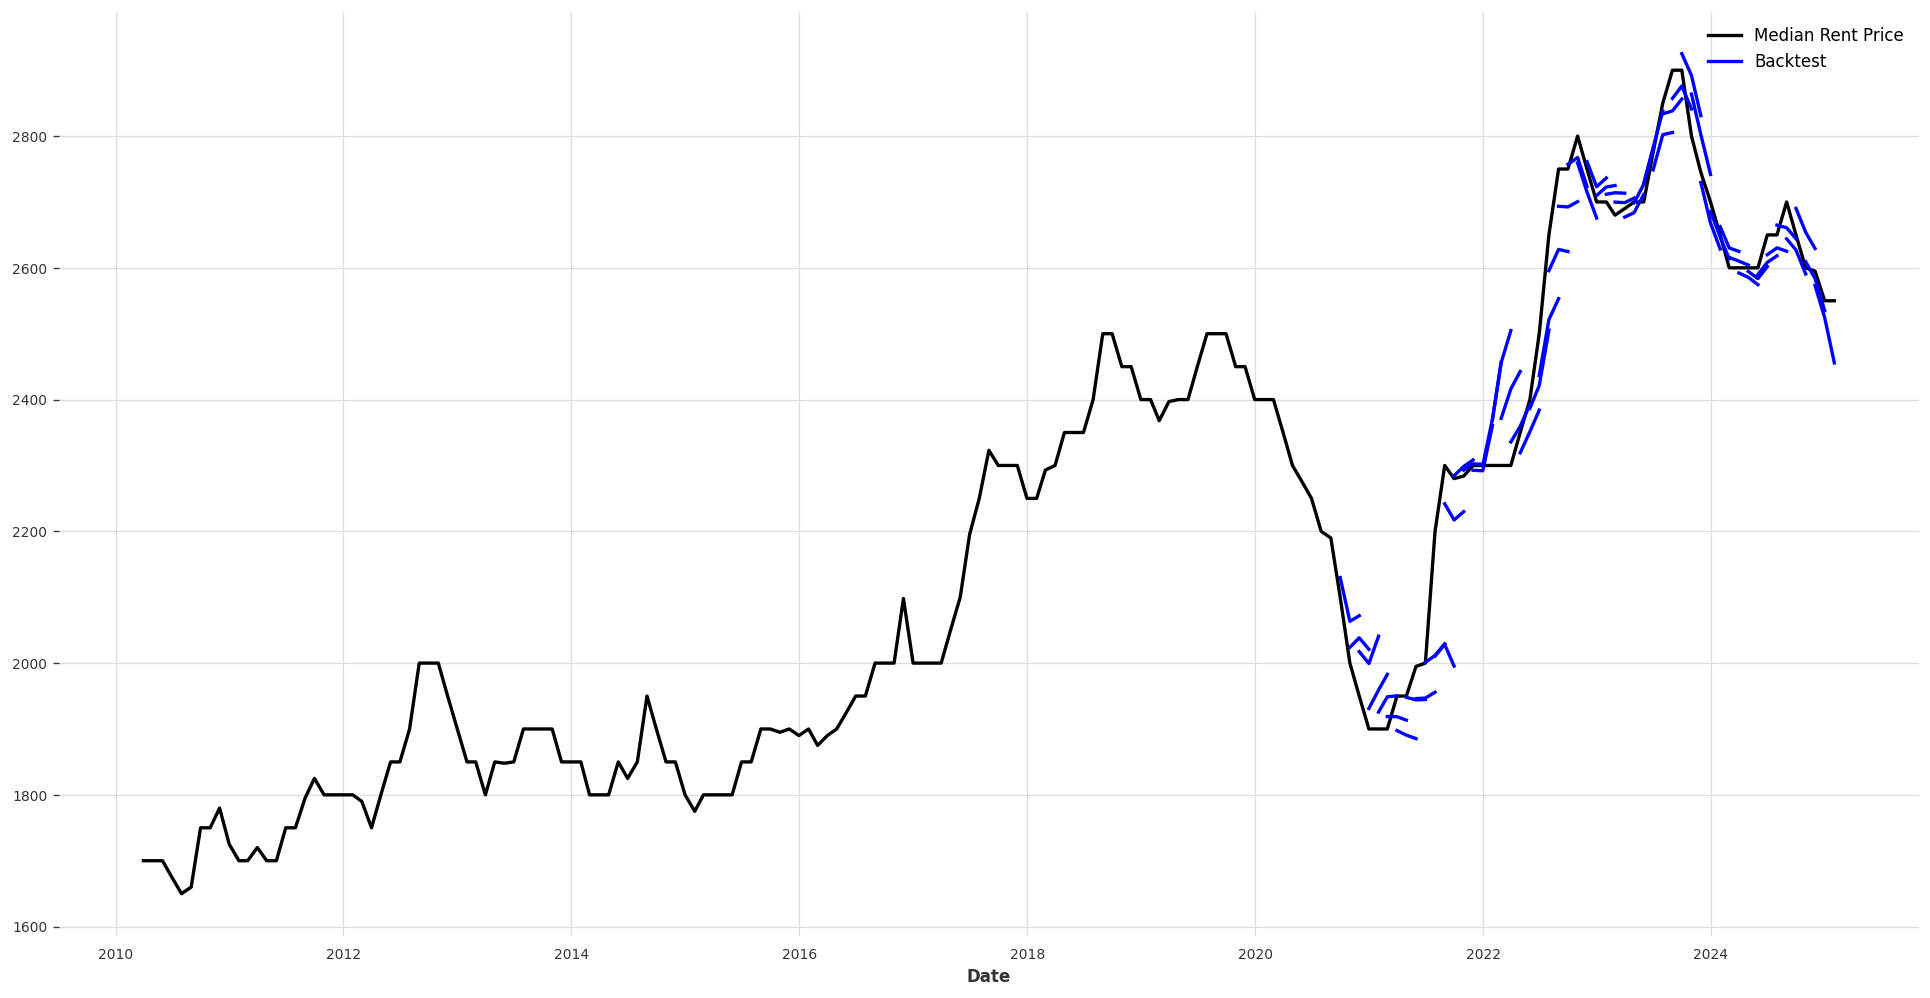

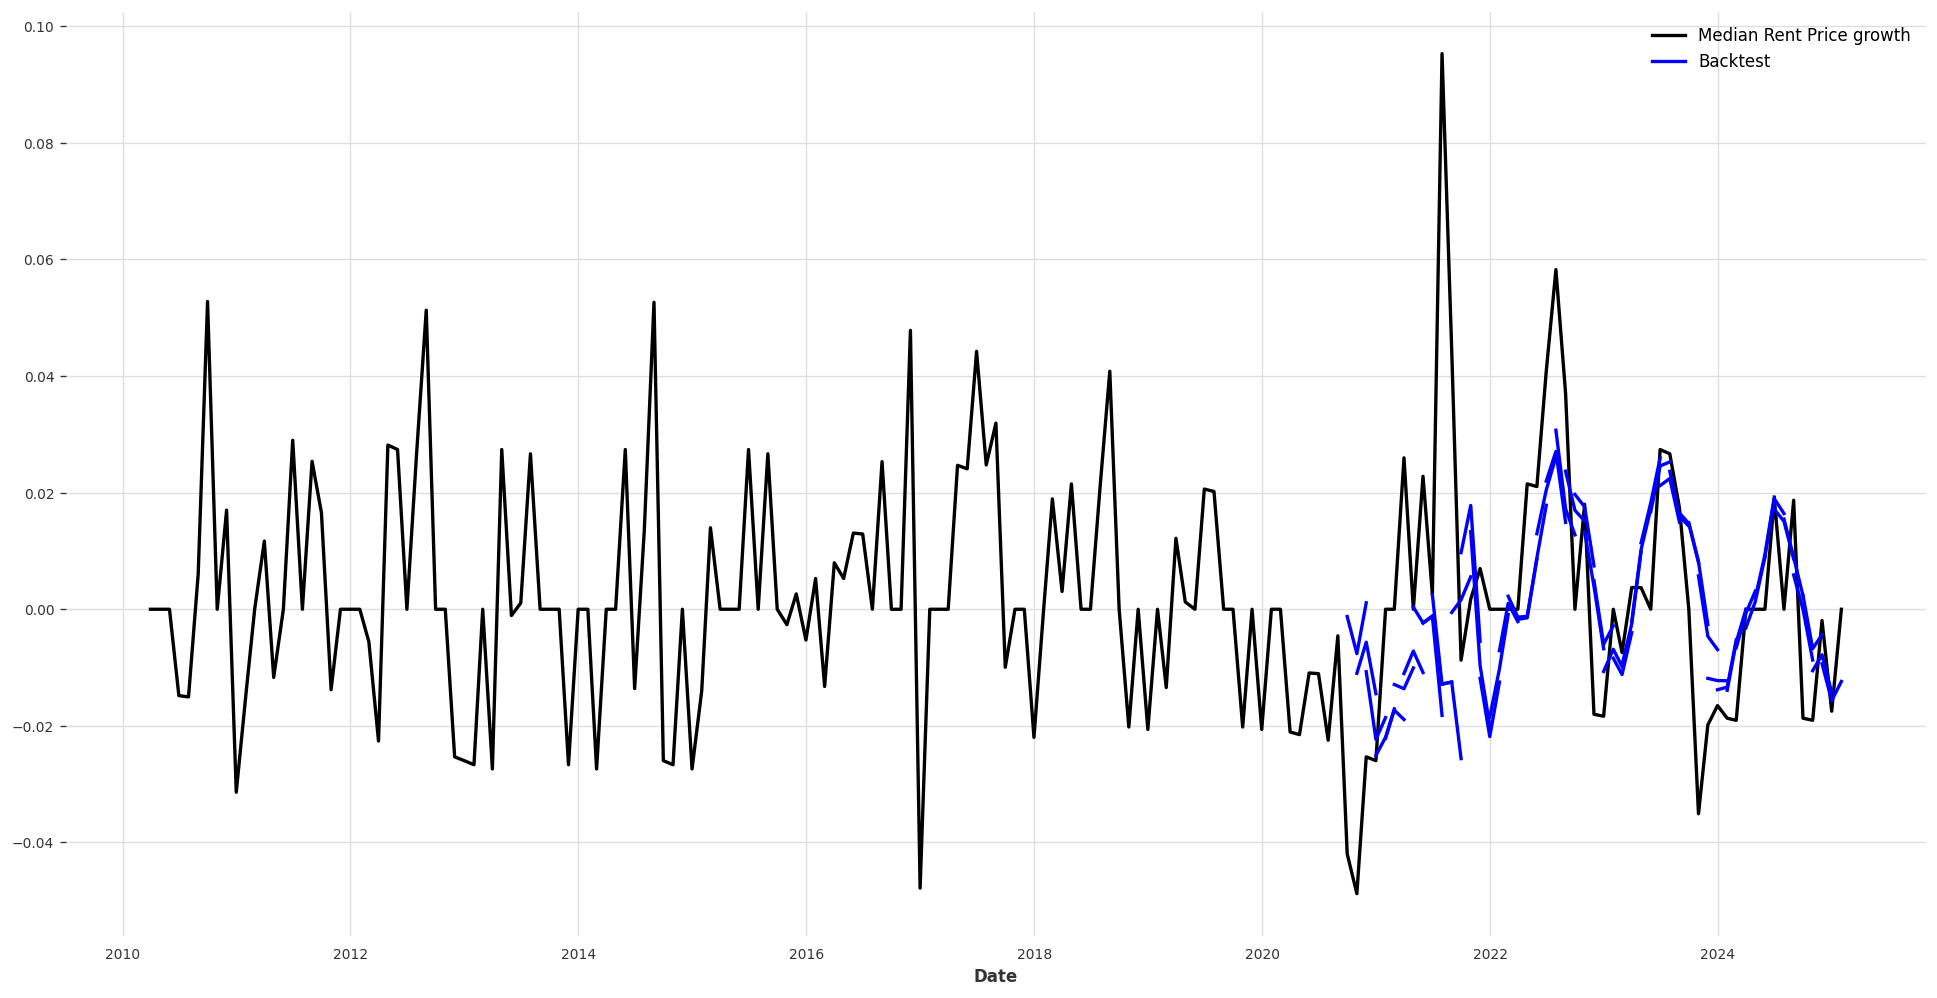

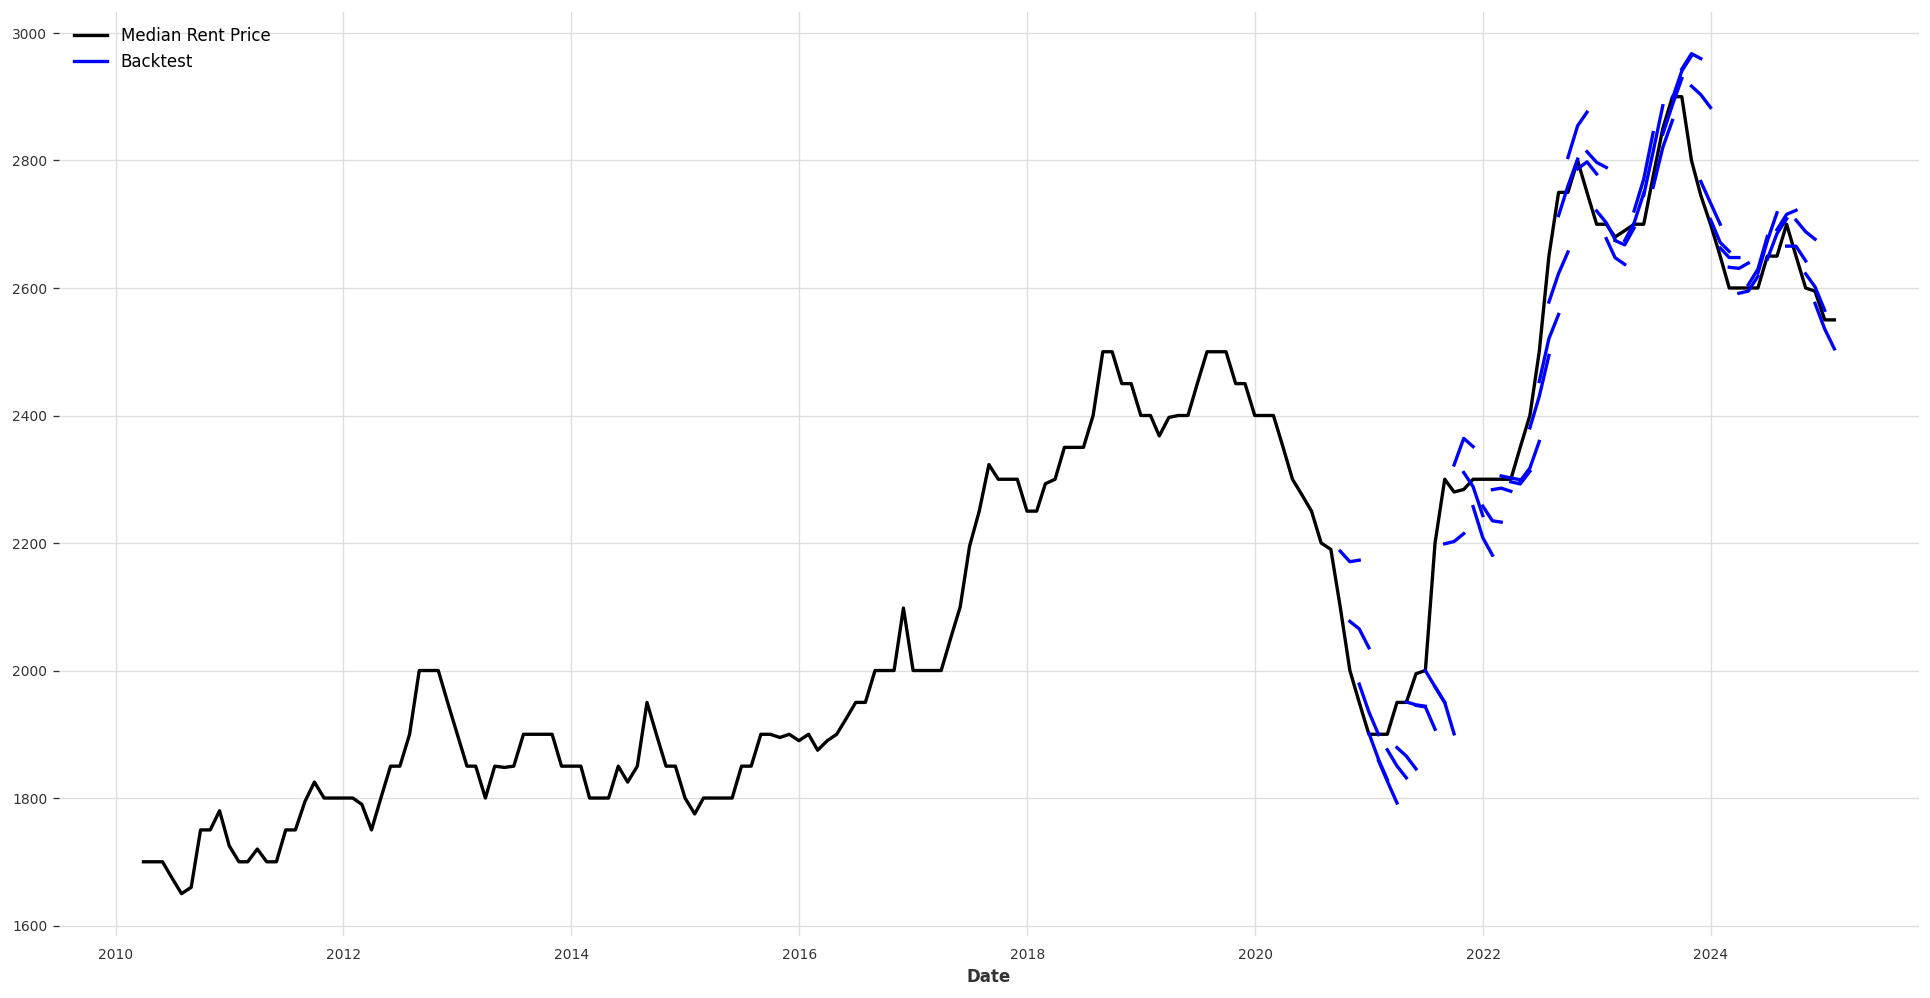

In [56]:
b = LR.historical_forecasts(
    y,
    future_covariates=cov,
    start=test_split_time,
    forecast_horizon=3,
    stride=1,
    last_points_only=False,
    retrain=True,
    overlap_end=False,
    verbose=False,
    enable_optimization=False,
)

eval_results(y, b, LR, [rmse, mase], title="Backtest")
eval_results(y1, b, LR, [rmse, mase, mape], inverse_transform=True, title="Backtest")
Naive = LinearRegressionModel(
    lags=12,  # [-1,-12],
    lags_future_covariates=None,
    output_chunk_length=1,
)
# Naive = NaiveSeasonal(12)
b = Naive.historical_forecasts(
    y,
    start=test_split_time,
    forecast_horizon=3,
    stride=1,
    last_points_only=False,
    retrain=True,
    overlap_end=False,
    verbose=False,
    enable_optimization=False,
)
eval_results(y, b, Naive, [rmse, mase])
eval_results(y1, b, Naive, [rmse, mase, mape], inverse_transform=True)

## Residual Analysis

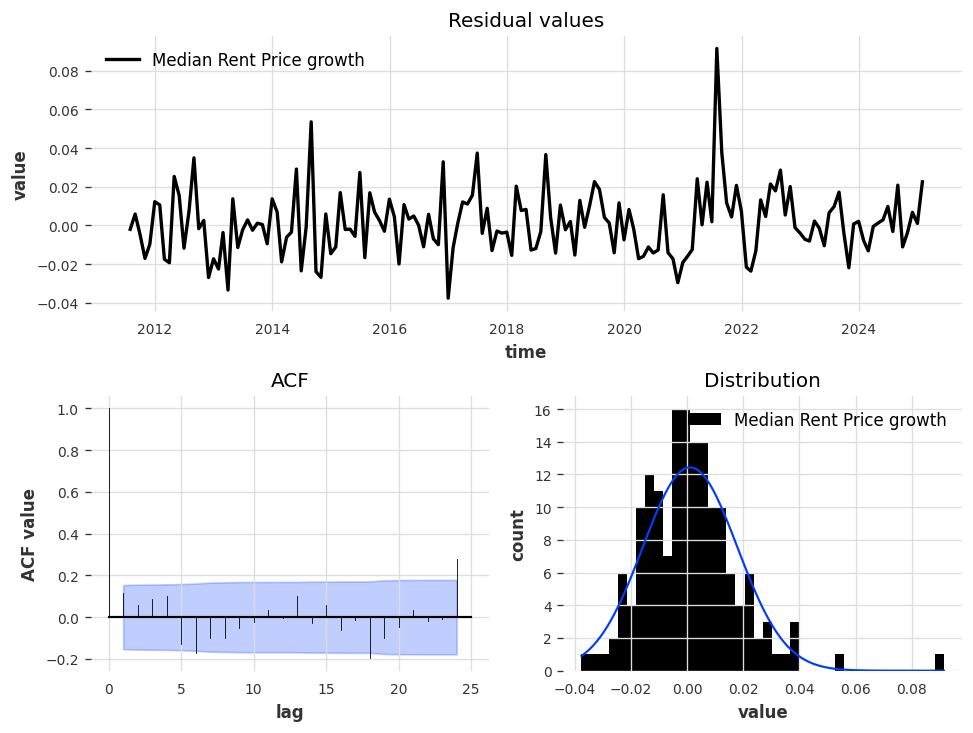

In [ ]:
residuals = LR.residuals(y, historical_forecasts=f)
plot_residuals_analysis(residuals, 40)

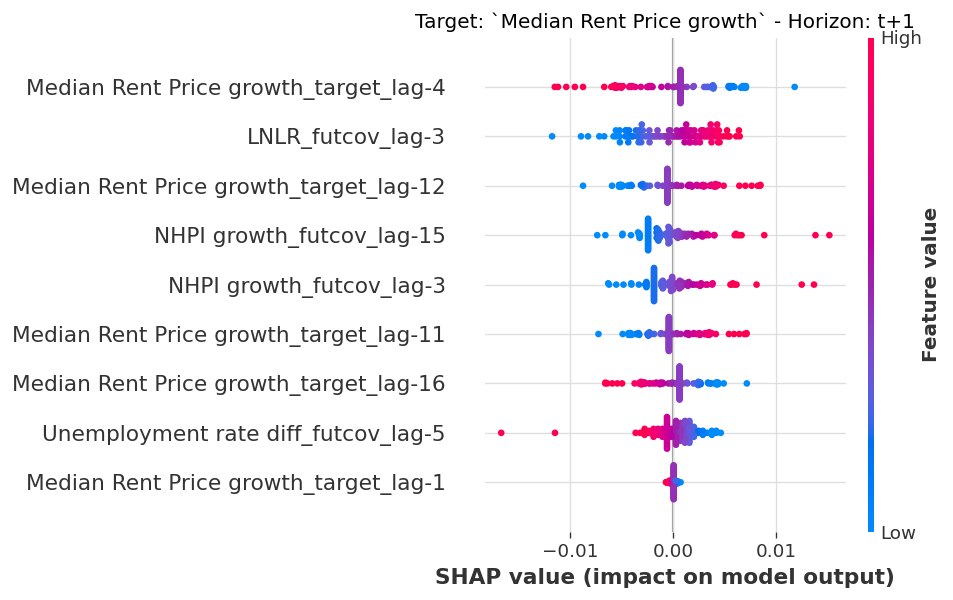

{1: {'Median Rent Price growth': .values =
  array([[ 6.15296791e-04, -3.14364836e-03,  4.43350095e-04,
          -2.00822206e-03, -3.64807850e-04, -1.30563909e-03,
           1.57774942e-03,  1.99643063e-03,  2.84842035e-03],
         [ 6.15296791e-04,  4.69897412e-04,  7.13586090e-03,
           3.42264249e-03,  4.42890419e-05,  3.21298115e-03,
          -3.65235915e-03,  5.80093435e-03,  1.10770207e-03],
         [ 6.15296791e-04,  8.48474291e-03, -4.21530696e-04,
           7.07210214e-04, -3.14025525e-04, -1.89707134e-04,
           1.57774942e-03,  3.83365958e-03,  5.47974907e-03],
         [ 2.64231278e-03, -5.65870196e-04,  2.01145709e-03,
          -6.02273384e-03, -1.89631030e-04, -1.31750321e-03,
           7.06064656e-04,  9.67580485e-04,  3.65464542e-03],
         [ 2.67279537e-03,  2.34783765e-03, -4.91408402e-03,
           7.07210214e-04,  2.38952191e-04, -1.98512281e-04,
           1.14190704e-03,  1.70070998e-05,  6.46916831e-03],
         [-2.11419180e-04, -5.9460812

In [ ]:
from darts.explainability.shap_explainer import ShapExplainer

shap_explain = ShapExplainer(LR)
shap_explain.summary_plot()

## Forecast

In [ ]:
LR.fit(y, future_covariates=cov)

forecast = LR.predict(3, y, future_covariates=cov)


FORECAST_PATH = "forecasts"
df_final = convert_forecast(y1.pd_dataframe(), forecast.pd_dataframe())
plot_forecast(df_final, target2).show()

component       Date  Median Rent Price Data Type
172       2024-07-31             2650.0    Actual
173       2024-08-31             2700.0    Actual
174       2024-09-30             2650.0    Actual
175       2024-10-31             2600.0    Actual
176       2024-11-30             2595.0    Actual
177       2024-12-31             2550.0    Actual
178       2025-01-31             2550.0    Actual
179       2025-02-28             2555.0  Forecast
180       2025-03-31             2552.0  Forecast
181       2025-04-30             2517.0  Forecast
